# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'2.3.1'

# Load Data

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print("Size of:")
print(" - Training-set:\t\t{}".format(len(x_train)))
print(" - Test-set:\t\t\t{}".format(len(x_test)))

Size of:
 - Training-set:		60000
 - Test-set:			10000


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
import sys
print("The Memory size of x_train = {} MBs".format(int(sys.getsizeof(x_train))/1000000))

The Memory size of x_train = 47.040128 MBs


# Helper function for plotting the images

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Data Dimensions

In [9]:
# We know that MNIST images are 28 pixels by 28 pixels
img_size = 28

# Images are stored in one-dimensional arrays of this length - number of numbers in the matrix of size 28 x 28
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image: 1 channel for gray-scale
num_channels = 1

# Number of classes, one class for each of 10 digits
num_classes = 10

# Visualise Data

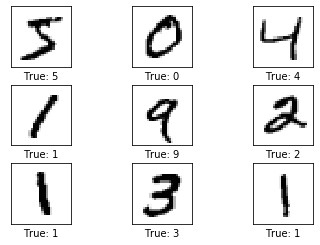

In [10]:
# Get the first images from the train set.
images = x_train[0:9]

# Get the true classes for those images.
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Hyperparameters of the Neural Network

In [11]:
# Convolutional layer 1
filter1_size = 5  #Convolution filters are 5 x 5 pixels
num_filters1 = 16 #There are 16 of these filters

# Convolutional layer 2
filter2_size = 5 #Convolution filters are 5 x 5 pixels
num_filters2 = 32 #There are 32 of these filters

# Pooling
window_size = 2 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=128     # Number of nodes in the fully-connected layer

# Convolution stride
conv_stride=1

# Transform the input data into the required shape/format

In [38]:
x_test.shape

(10000, 28, 28)

In [16]:
# Prepare the input data - Just taking the first 1000 images stay within the compute resource limitation
x_training = tf.constant(x_train[:1000], tf.float32)
y_training = tf.constant(y_train[:1000], tf.int64)
# Prepare the input data
x_testing = tf.constant(x_test[:1000], tf.float32)
y_testing = tf.constant(y_test[:1000], tf.int64)

In [17]:
x_training.shape, y_training.shape

(TensorShape([1000, 28, 28]), TensorShape([1000]))

In [19]:
y_training[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([5, 0, 4, 1, 9])>

In [20]:
# Reshape as required for ConvNet
new_shape = [-1, img_size, img_size, num_channels]
x_image = tf.reshape(tensor = x_training, shape = new_shape)
y_image = tf.one_hot(y_training,depth=10) # One-hot encoding of the target variable as required by the model
x = tf.reshape(tensor = x_testing, shape = new_shape)
y = tf.one_hot(y_testing,depth=10) # One-hot encoding of the target variable as required by the model

In [21]:
x_image.shape

TensorShape([1000, 28, 28, 1])

In [22]:
y_image.shape

TensorShape([1000, 10])

In [23]:
# Package the data into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_image, y_image)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(32)

In [39]:
train_ds

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [40]:
test_ds

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

## Helper function for Creating Weights

In [26]:
def weights(shape):
    weights = tf.Variable(tf.random.normal(shape=shape, stddev=0.05))
    return weights

## Helper function for Flat Layer

In [27]:
def flatten_layer(layer):
    # Get the shape of the layer
    layer_shape = layer.get_shape()
    # Calculate the number of features for each image which is img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    flat_layer = tf.reshape(layer, [-1, num_features])
    return flat_layer, num_features

## Define Weights of the Fully Connected Network

In [41]:
# Define the architecture of the model
def nn_forward(image):
    # Conv1 layer
    shape_1 = [5, 5, 1, 16]
    shape_bias1 = [1, 28, 28, 16]
    conv1_weights = weights(shape_1)
    bias_1 = tf.Variable(tf.ones(shape=shape_bias1))
    conv1 = tf.nn.conv2d(input=image, filters=conv1_weights, strides=1, padding='SAME')
    conv1+=bias_1
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(input=conv1, ksize=2, strides=2, padding='SAME')
    # Conv2 Layer
    shape_2 = [5, 5, 16, 32]
    shape_bias2 = [1, conv1.shape[1], conv1.shape[1], 32]
    conv2_weights = weights(shape_2)
    bias_2 = tf.Variable(tf.ones(shape=shape_bias2))
    conv2 = tf.nn.conv2d(input=conv1, filters=conv2_weights, strides=1, padding='SAME')
    conv2+=bias_2
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(input=conv2, ksize=2, strides=2, padding='SAME')
    # Flat Layer
    flat_layer, num_features = flatten_layer(conv2)
    return flat_layer, num_features

In [42]:
# Fully connected layer
fc_shape = [1568, fc_size]
fc_weights = tf.Variable(tf.random.normal(shape=fc_shape))
bias_fc = tf.Variable(tf.ones([fc_size]))
# Output layer
shape_out = [fc_size, num_classes]
w_out = tf.Variable(tf.random.normal(shape=shape_out))
b_out = tf.Variable(tf.ones([num_classes]))

## Helper-function for the loss function

In [43]:
def nn_loss_function(image, actual):
    flat_layer, num_features = nn_forward(image)
    #Fully connected layer
    fc_product = tf.matmul(flat_layer, fc_weights)
    fully_connected = tf.keras.activations.relu(fc_product+bias_fc)
    # Output layer
    output = tf.matmul(fully_connected, w_out)
    prediction = tf.keras.activations.softmax(output + b_out)
    loss = tf.keras.losses.categorical_crossentropy(actual, prediction)
    return loss, prediction

## Compile and Train the model

In [44]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [45]:
train_loss

In [46]:
optimizer = tf.keras.optimizers.Adam()

In [47]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        loss, predictions = nn_loss_function(images, labels)
    gradients = tape.gradient(loss, [fc_weights, bias_fc, w_out, b_out])
    optimizer.apply_gradients(zip(gradients, [fc_weights, bias_fc, w_out, b_out]))
    train_loss(loss)
    train_accuracy(labels, predictions)

In [48]:
@tf.function
def test_step(images, labels):
    t_loss, predictions = nn_loss_function(labels)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [49]:
train_ds

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [50]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}')

ValueError: in user code:

    <ipython-input-47-33adeeb473f7>:8 train_step  *
        train_accuracy(labels, predictions)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:231 __call__  **
        replica_local_fn, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/distribute/distributed_training_utils.py:1133 call_replica_local_fn
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:211 replica_local_fn
        update_op = self.update_state(*args, **kwargs)  # pylint: disable=not-callable
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:3301 sparse_categorical_accuracy
        y_true = array_ops.squeeze(y_true, [-1])
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:4259 squeeze
        return gen_array_ops.squeeze(input, axis, name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py:10044 squeeze
        "Squeeze", input=input, squeeze_dims=axis, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 10 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](labels)' with input shapes: [32,10].


In [ ]:
# Train the model by learning the optimal weights

opt = tf.keras.optimizers.Adam(0.5) # 1.Initialize optimizer with learning rate of 0.5

for j in range(1000): # 2. Search for the optimal values for the weights
    prediction = nn_forward(flat_layer, weight_fc, bias_fc, weight_out, bias_out)
    opt.minimize(lambda: nn_loss_function(flat_layer, weight_fc, bias_fc, weight_out, bias_out, y_image), var_list=[weight_fc, bias_fc, weight_out, bias_out])
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_image, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
accuracy.numpy()

## Print out the optimized weights

In [ ]:
weight_fc.numpy()

In [ ]:
weight_out.numpy()

## Make prediction with the optimal weights

In [ ]:
prediction = nn_forward(flat_layer, weight_fc, bias_fc, weight_out, bias_out)

## Evaluate the model

In [ ]:
# Accuracy
sum((tf.argmax(prediction, axis=1)==y_image).numpy())/len(y_image.numpy())